# Some instructions

In [1]:
# This lets us change the eb.py file and run the notebook simultaenously,
# without having to reload the notebook every time!
% load_ext autoreload
% autoreload 2

In [2]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from astropy.modeling import fitting, models

In [4]:
import lightkurve as lk
import chromo
from chromo import eb
from chromo.utils import background_correct, poly_detrend

In [5]:
from scipy.stats import pearsonr

# Spot Free Bright EBs

* [R CMa](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=%40976454&Name=V*%20R%20CMa&submit=submit)
* [Zeta Phe](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=%403564141&Name=*%20zet%20Phe&submit=submit)
* [AE Phe](link) Very Contact Binary
* [XZ Pup](link) Very good pupper
* [WZ Hor](link) Faint colour signal, but super nice

# No Saturation EBs

* [EE Aqr](link) Excellent
* [SZ Pic]

### Less good with spots but still OK EBs

* V461 Car
* V415 CMa
* kap01 Ind
* AR Dor
* AL Scl
* Del Pic

### Fun EBs
* CF Tuc

### Maybe Colour Free EBs?

* CN Hyi


#### Also EBs
* m Pup

In [6]:
# Grab an object
tic = 'EE Aqr '

In [7]:
sr = lk.search_tesscut(tic)

In [8]:
sr

SearchResult containing 1 data products.

target_name productFilename        description         distance
----------- --------------- -------------------------- --------
    EE Aqr              n/a TESS FFI Cutout (sector 2)      0.0

In [9]:
# Download an FFI cut out!
raw_tpf = sr[0].download(cutout_size=[30, 30])

# Cut out any jitter
k = ~((raw_tpf.time > 1346) & (raw_tpf.time < 1350))
raw_tpf = raw_tpf[k]

# No nan frames
raw_tpf = raw_tpf[(raw_tpf.to_lightcurve().flux > 0)]

In [10]:
tpf = background_correct(raw_tpf)

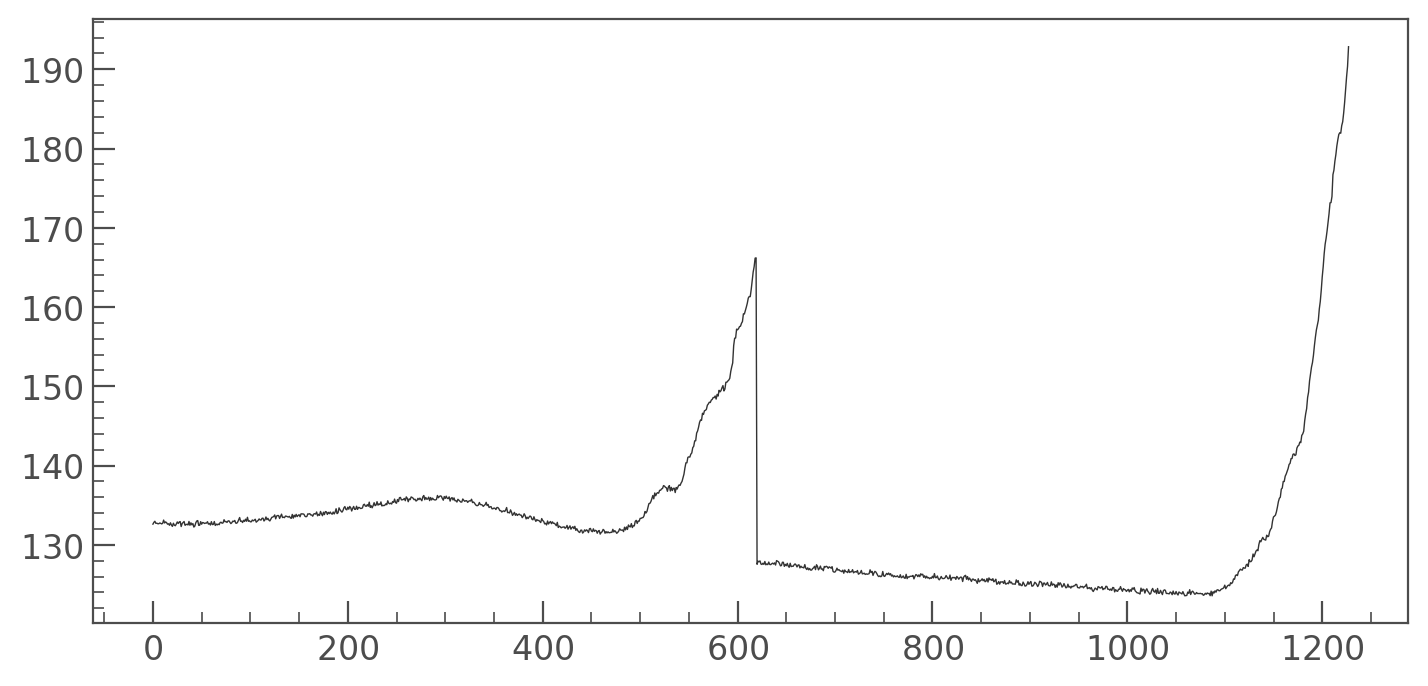

In [11]:
plt.plot(chromo.utils._estimate_background(raw_tpf))

In [12]:
flux = np.copy(raw_tpf.flux)
thumb = np.nanpercentile(flux, 95, axis=0)
thumb[thumb > 1e3] = np.nan
mask = thumb > np.nanpercentile(thumb, 20)
mask |= ~np.isfinite(thumb)

# Make sure to throw away nans
#mask[~np.isfinite(thumb)] = True

/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


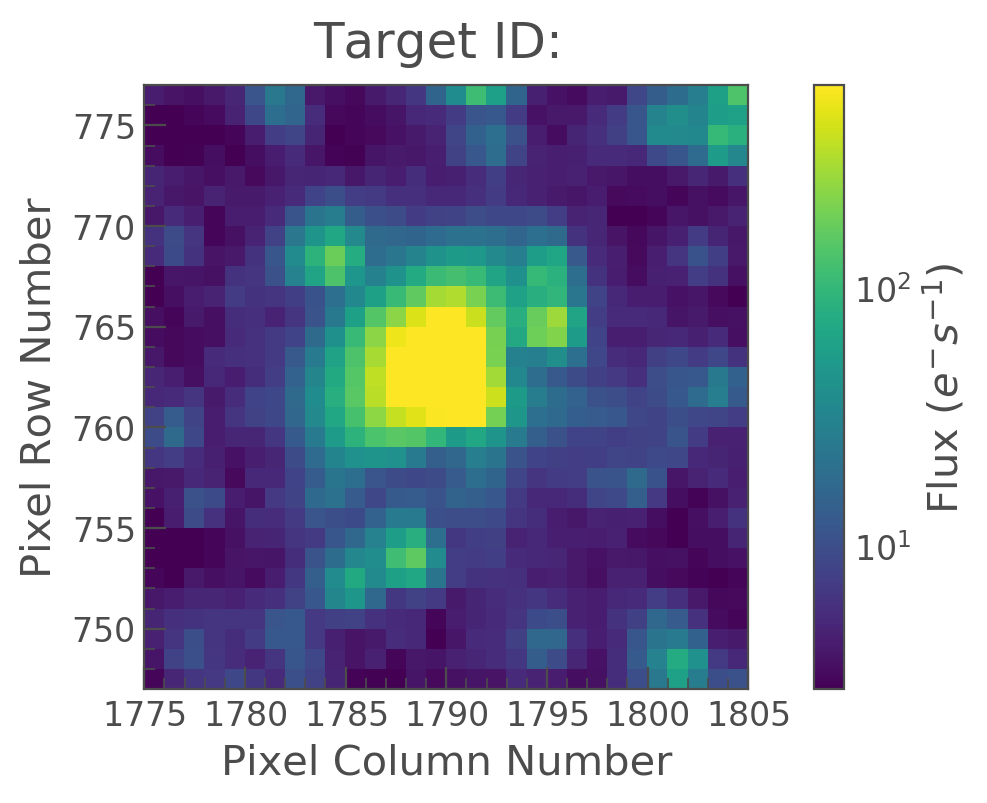

In [13]:
tpf.plot(scale='log')

In [14]:
tpf.row, tpf.column

(747, 1775)

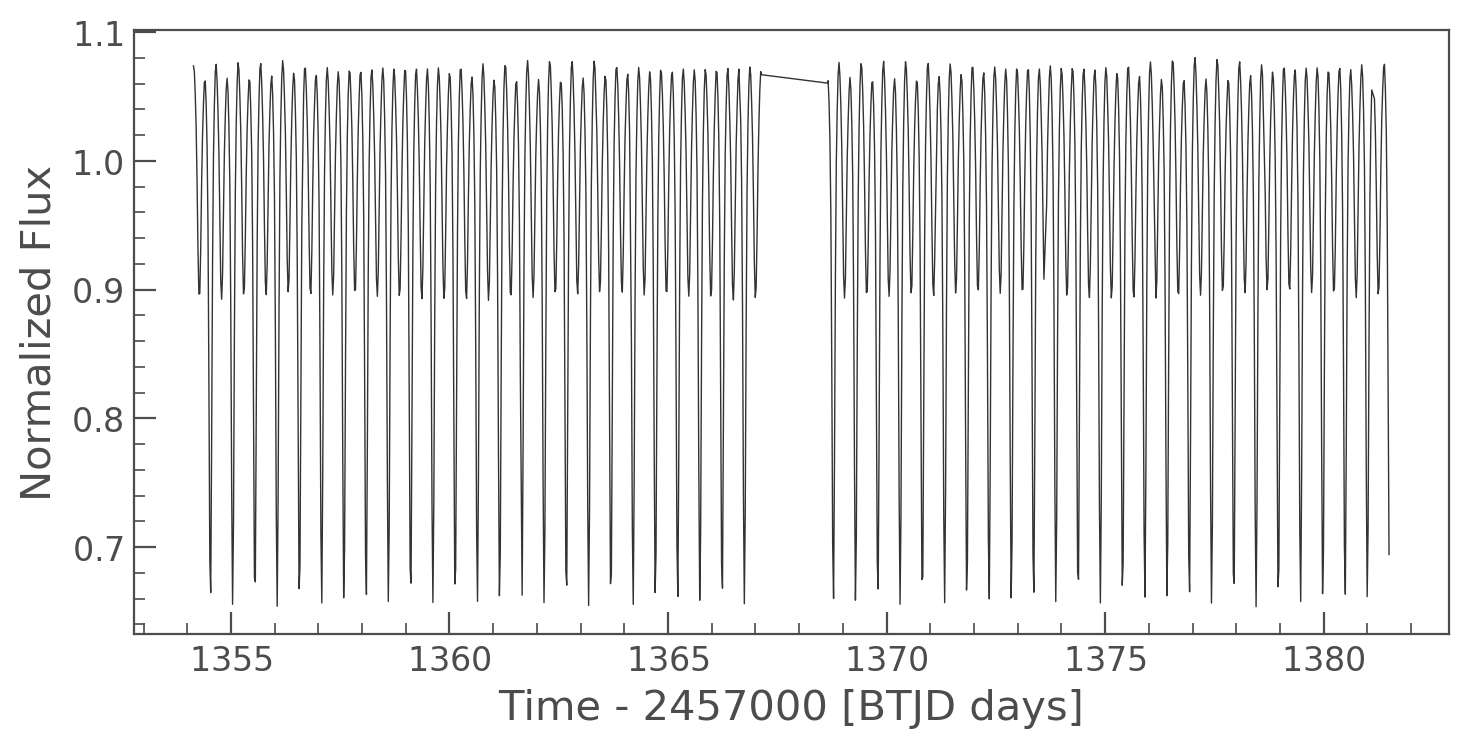

In [15]:
# Take a look!
lc = tpf.to_lightcurve().normalize()
lc.plot()

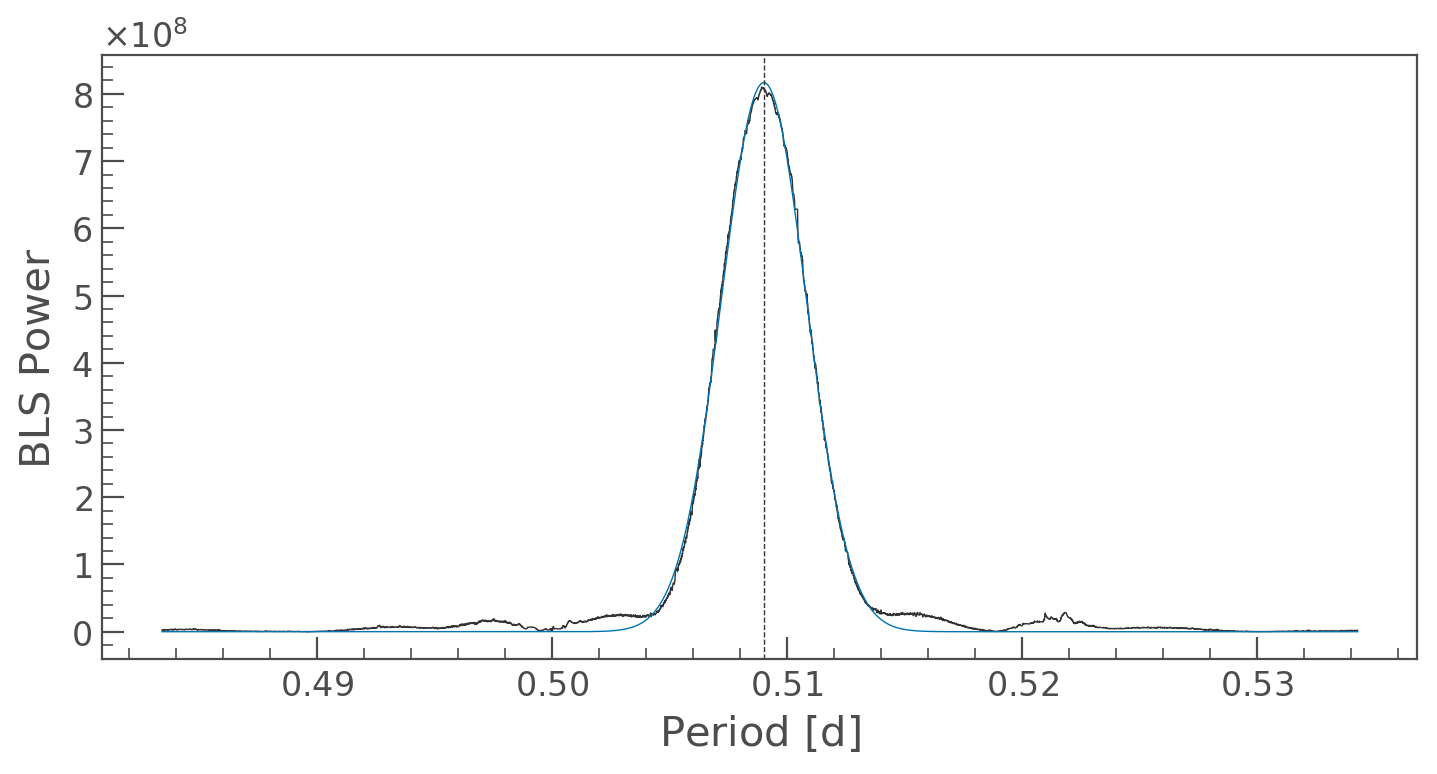

In [16]:
# Find the period and t0 using a BLS!

duration = 0.1
minimum_period = 0.5
p = lc.to_periodogram('bls', duration=duration, minimum_period=minimum_period, maximum_period=15)
period = p.period_at_max_power.value
p = lc.to_periodogram('bls', duration=duration, minimum_period=period * 0.95, maximum_period=period * 1.05, frequency_factor=0.1)

ax = p.plot()
g_init = models.Gaussian1D(p.power.value.max(), p.period.value.mean(), 0.002) + models.Gaussian1D(p.power.value.max()*0.01, p.period.value.mean(), 0.002)
fit = fitting.LevMarLSQFitter()
g = fit(g_init, p.period.value, p.power.value)
mean = getattr(g, 'mean_{}'.format(np.argmax([g.amplitude_0, g.amplitude_1]))).value
ax.plot(p.period.value, g(p.period.value))
plt.axvline(mean, ls='--')
pos = np.argmin(np.abs(p.period.value - mean))
period, t0 = p.period[pos].value, p.transit_time[pos]

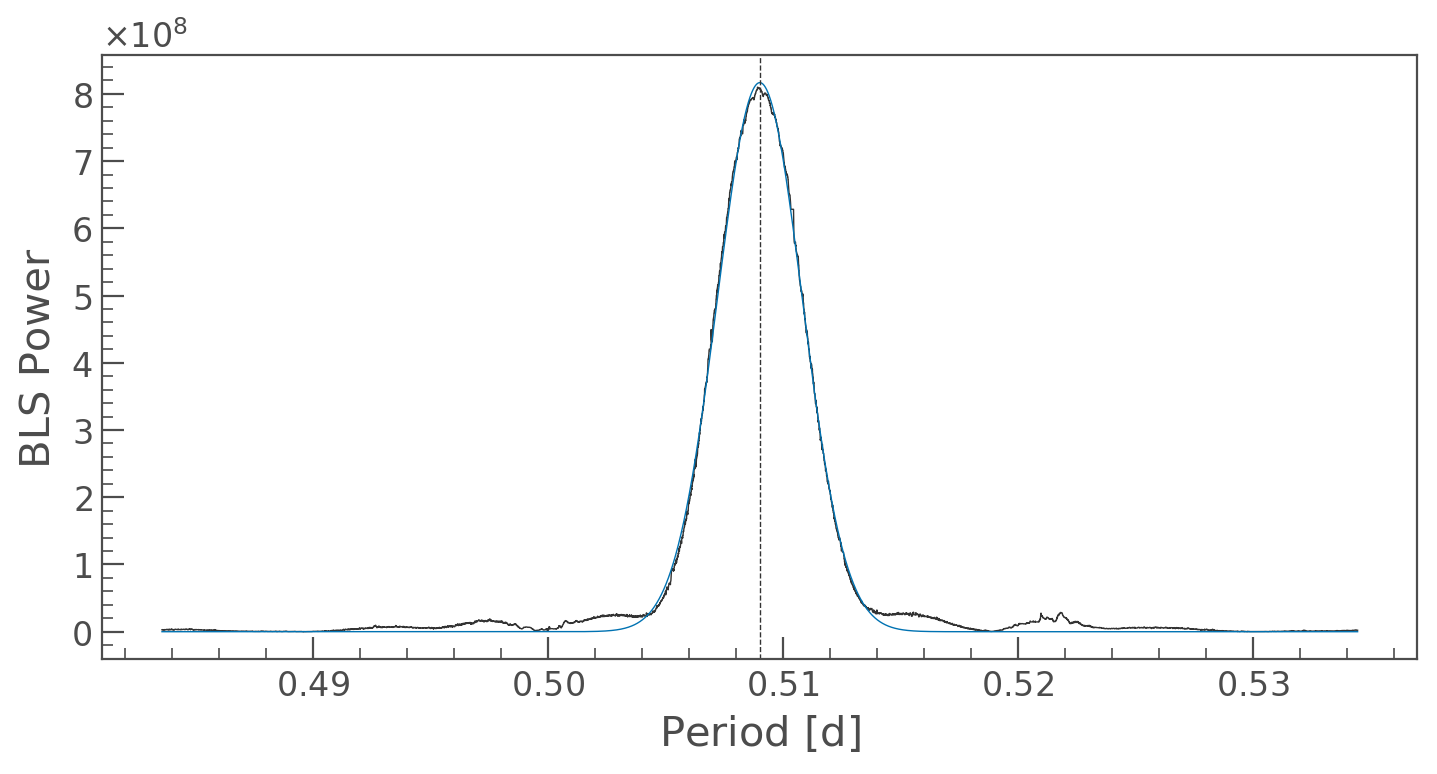

In [17]:
nb = 100
x_fold = (lc.time - t0 - period/2) / period % 1 - 0.5
inds = np.array_split(np.argsort(x_fold), np.linspace(0, len(x_fold), nb + 1, dtype=int))[1:-1]
x_fold_b = np.asarray([np.median(x_fold[ind]) for ind in inds])
flux_b = np.asarray([np.median(lc.flux[ind]) for ind in inds])
flux_b /= np.nanmedian(lc.flux)

func = interp1d(x_fold_b[np.argsort(x_fold_b)], flux_b[np.argsort(x_fold_b)],
                kind='cubic', fill_value='extrapolate')
eb_model = func(x_fold)
clc = lc/poly_detrend(lc, eb_model).flux


p = clc.to_periodogram('bls', duration=duration, minimum_period=period * 0.95, maximum_period=period * 1.05, frequency_factor=0.1)

ax = p.plot()
g_init = models.Gaussian1D(p.power.value.max(), p.period.value.mean(), 0.002) + models.Gaussian1D(p.power.value.max()*0.01, p.period.value.mean(), 0.002)
fit = fitting.LevMarLSQFitter()
g = fit(g_init, p.period.value, p.power.value)
mean = getattr(g, 'mean_{}'.format(np.argmax([g.amplitude_0, g.amplitude_1]))).value
ax.plot(p.period.value, g(p.period.value))
plt.axvline(mean, ls='--')
pos = np.argmin(np.abs(p.period.value - mean))
period, t0 = p.period[pos].value, p.transit_time[pos]

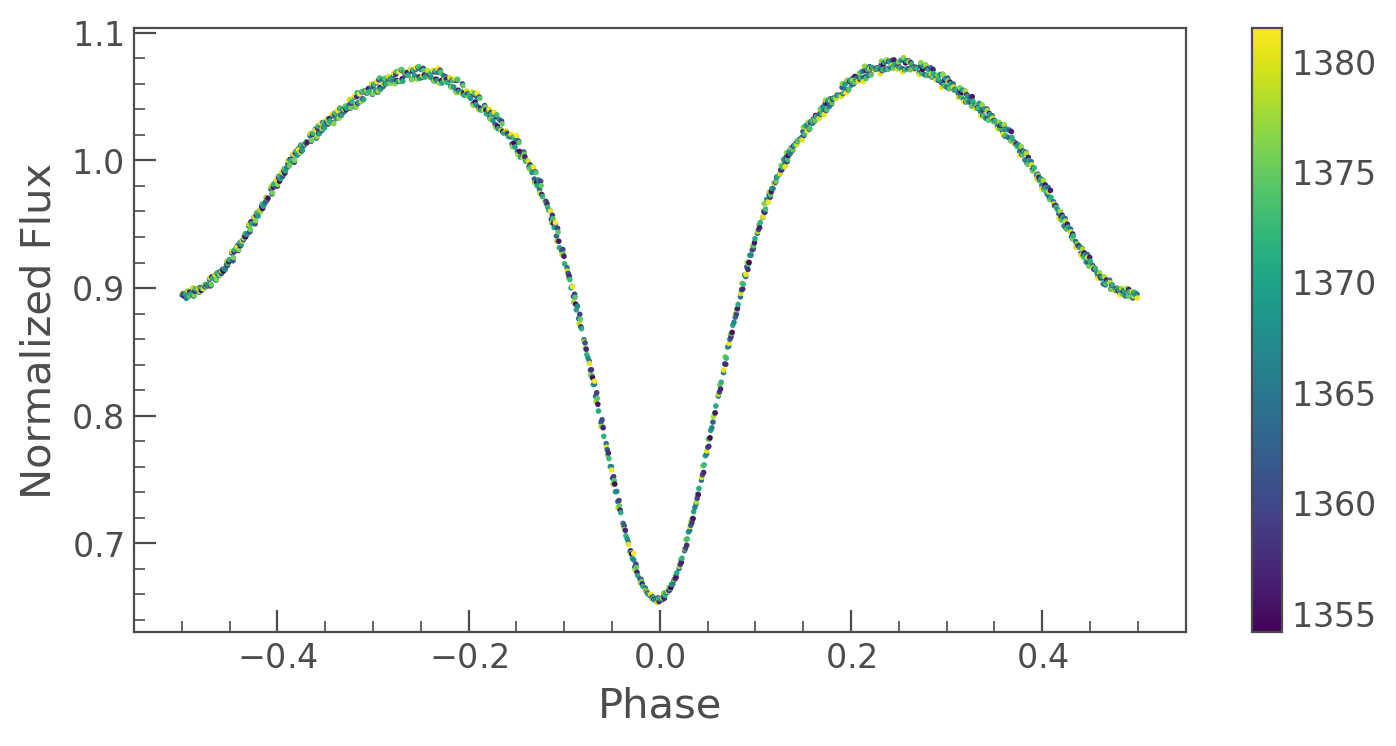

In [18]:
f = clc.fold(period, t0)
f.scatter(c=f.time_original)

Calculating Pixel Light Curves: 100%|██████████| 30/30 [00:02<00:00, 11.33it/s]


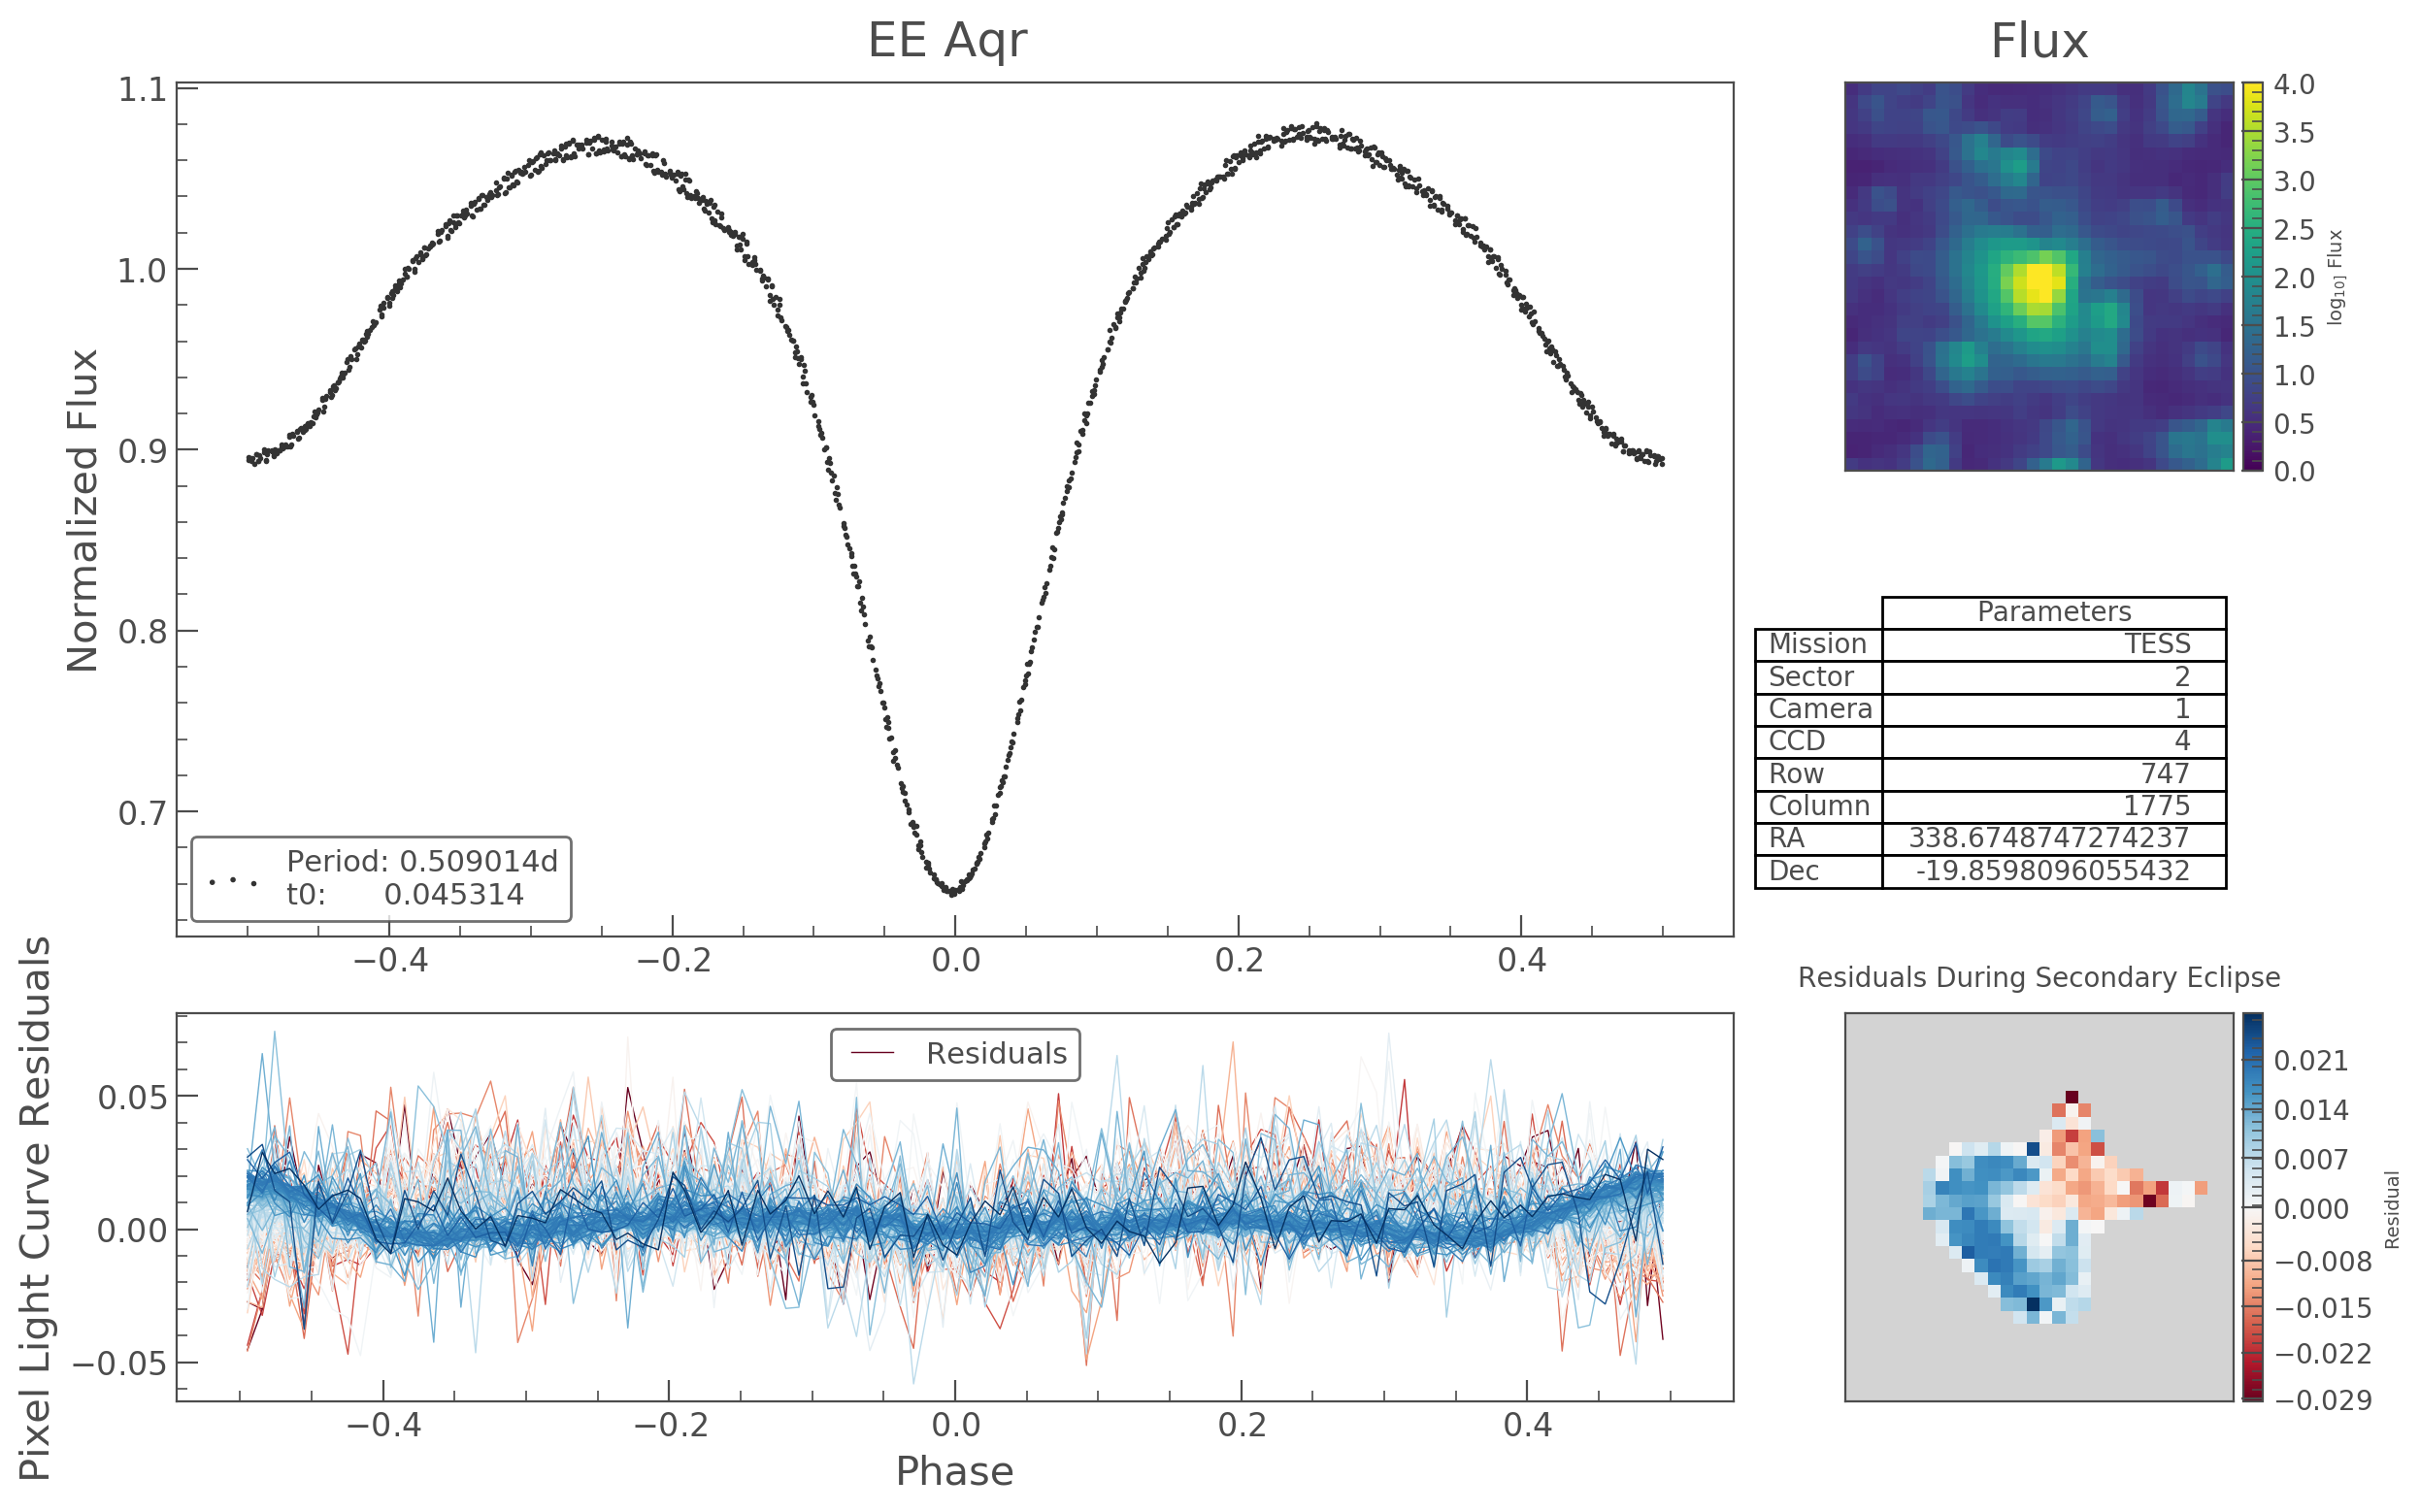

In [99]:
# Use Chromo to analyze! This will make movies in your current directory!
result = eb.analyze(raw_tpf, period, t0, name='{}'.format(tic), nb=100);

Calculating Pixel Light Curves: 100%|██████████| 20/20 [00:01<00:00, 17.49it/s]


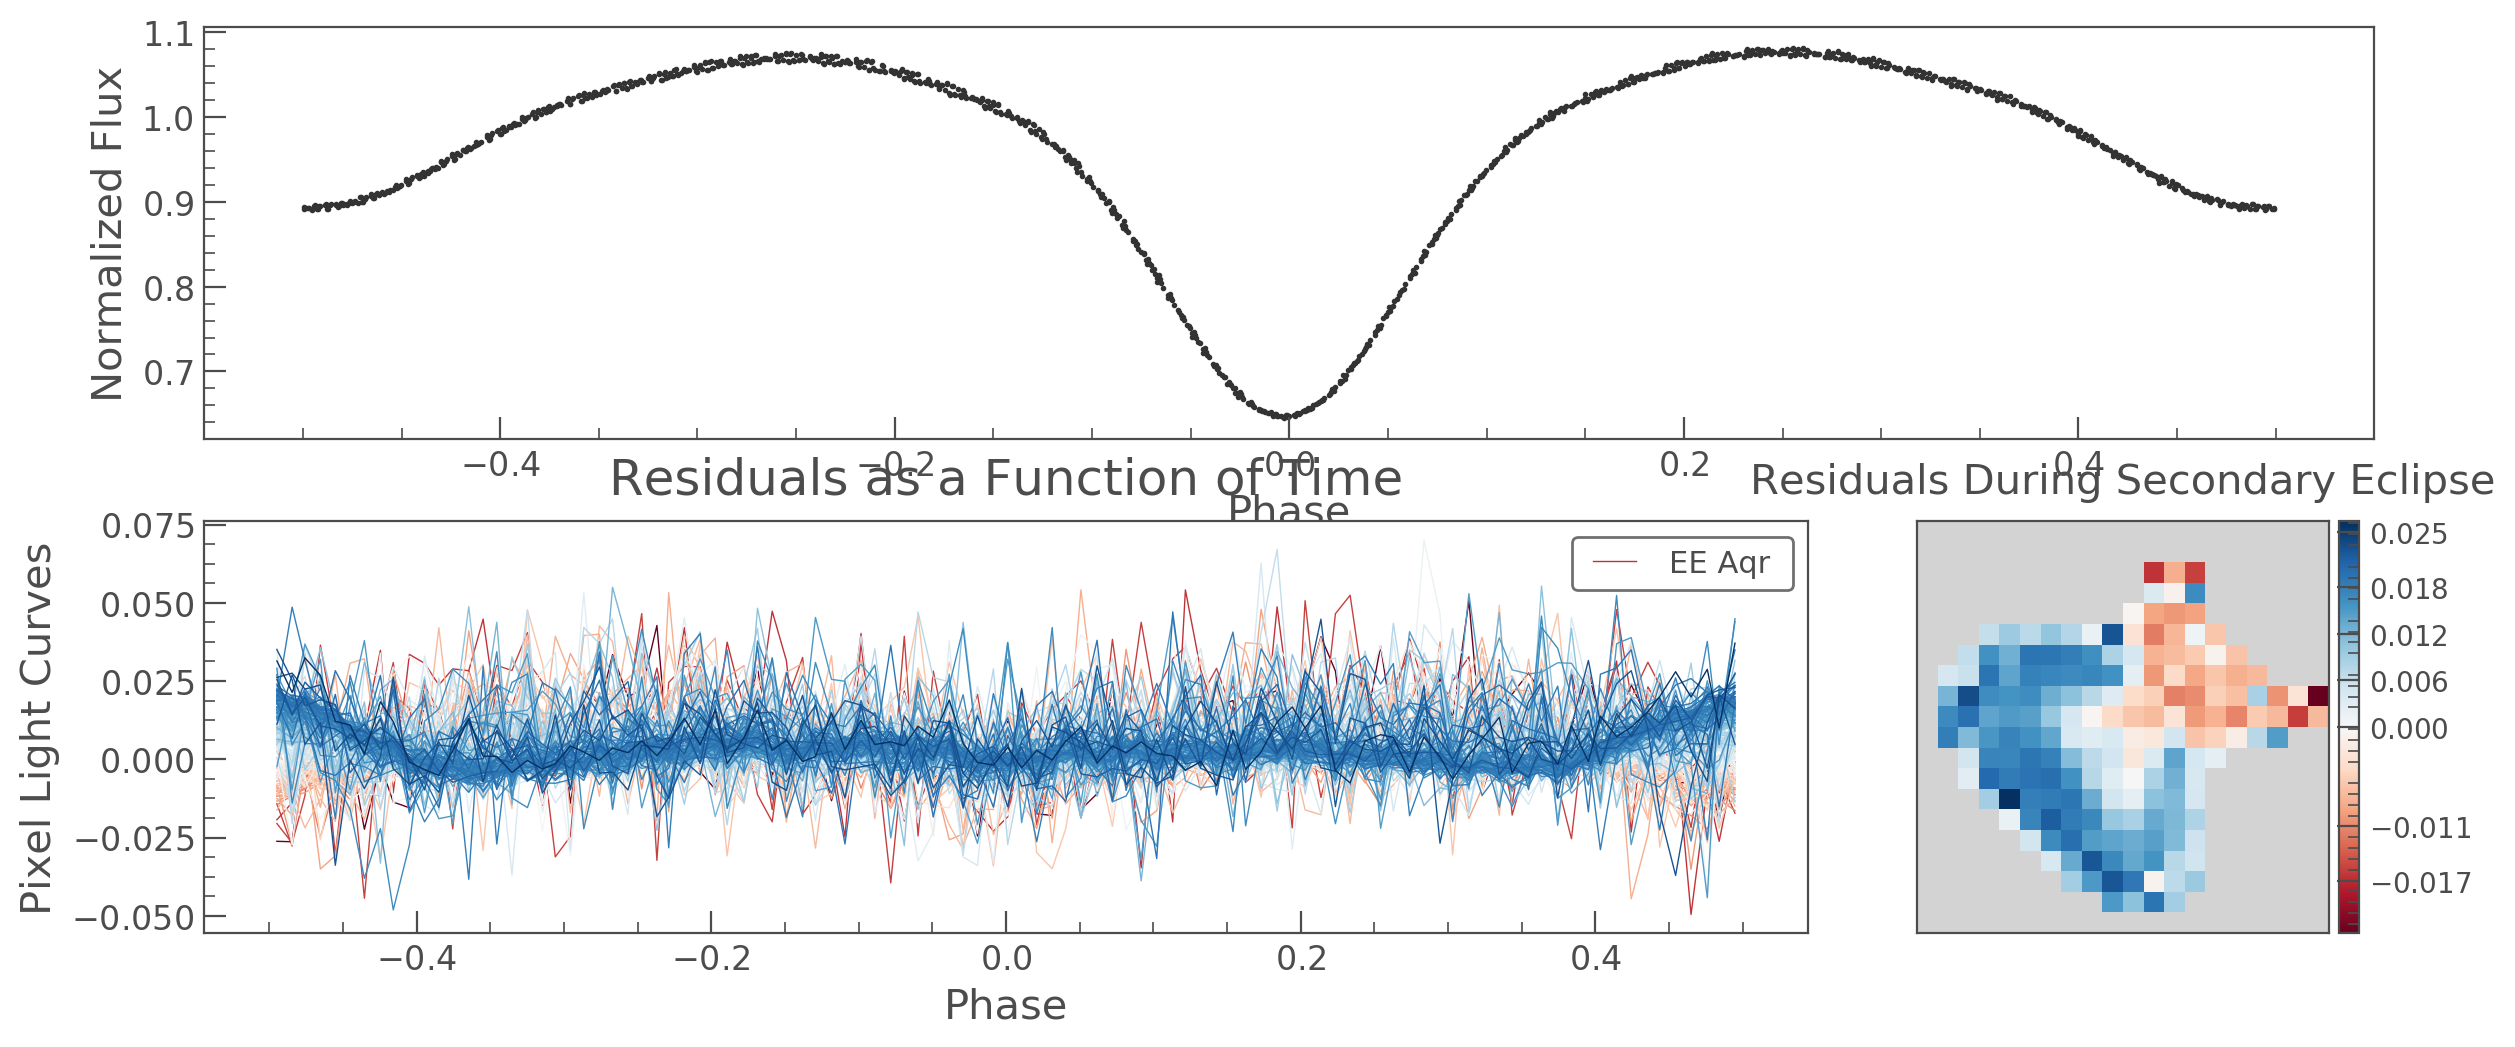

In [20]:
# Use Chromo to analyze all Sectors!
_ = [eb.analyze(raw_tpf, period, t0, name='{}'.format(tic), nb=100) for raw_tpf in sr.download_all(cutout_size=[20, 20])]

In [80]:
labels = ['sector', 'camera', 'ccd', 'row', 'column', 'mag']
plt.table(cellText=np.atleast_2d(np.asarray([getattr(tpf, l) for l in labels])).T, rowLabels=np.asarray(labels), colLabels=np.asarray(['Parameters']))

AttributeError: 'TessTargetPixelFile' object has no attribute 'mag'

In [84]:
tpf.__dir__()

['path',
 '_hdu',
 'quality_bitmask',
 'targetid',
 'quality_mask',
 '_last_aperture_mask',
 '__module__',
 '__doc__',
 '__init__',
 '__repr__',
 'background_mask',
 'sector',
 'camera',
 'ccd',
 'mission',
 'astropy_time',
 'extract_aperture_photometry',
 'get_bkg_lightcurve',
 '__getitem__',
 'hdu',
 'get_keyword',
 'header',
 'ra',
 'dec',
 'column',
 'row',
 'pos_corr1',
 'pos_corr2',
 'pipeline_mask',
 'shape',
 'time',
 'cadenceno',
 'nan_time_mask',
 'flux',
 'flux_err',
 'flux_bkg',
 'flux_bkg_err',
 'quality',
 'wcs',
 'from_fits',
 'get_coordinates',
 'show_properties',
 'to_lightcurve',
 '_parse_aperture_mask',
 'create_threshold_mask',
 'centroids',
 'estimate_centroids',
 'plot',
 'to_fits',
 'interact',
 'interact_sky',
 'to_corrector',
 '__dict__',
 '__weakref__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',


In [ ]:
tpf.ccd

In [ ]:
tpf.plot(scale='log')